# Sentiment Analysis of Hotel Reviews
This jupyter note book analysis of 515738 hotel reviews scrapped from the web. If you would like to look at the original dataset on Kaggle you could search for '515K Hotel Reviews Data in Europe' or use the following link: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe

## Clean and Edit Dataset

### Importing Data and Libraries

In [79]:
# Importing Libraries
import pandas as pd
import time
import nltk as nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Load the data
print('Loading data file now, this could take a while depending on the file size')
start = time.time()

df = pd.read_csv('../data/Hotel_Reviews.csv')
end = time.time()
print('Loading took ' + str(round(end - start, 2)) + ' seconds')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jeevsidak/nltk_data...


Loading data file now, this could take a while depending on the file size
Loading took 1.7 seconds


### Explore the data

In [64]:
# Check how big our dataset is
print('The shape of the data is: ' + str(df.shape))

The shape of the data is: (515738, 17)


In [65]:
# Explore the different columns in the dataset and their values
nationality_freq = df['Reviewer_Nationality'].value_counts()
print('There are ' + str(nationality_freq.size) + ' different nationalities')
print(nationality_freq)

There are 227 different nationalities
 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Cape Verde                        1
 Northern Mariana Islands          1
 Tuvalu                            1
 Guinea                            1
 Palau                             1
Name: Reviewer_Nationality, Length: 227, dtype: int64


In [66]:
print('The ten most frequent nationalities are \n' + str(nationality_freq[:10]))

The ten most frequent nationalities are 
 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
Name: Reviewer_Nationality, dtype: int64


In [67]:
for nat in nationality_freq[:10].index:
    nat_df = df[df['Reviewer_Nationality'] == nat]

    freq = nat_df['Hotel_Name'].value_counts()
    print('The most reviewed hotel for ' + str(nat).strip() + ' was ' + str(freq.index[0]) + ' with ' + str(freq[0]) + ' reviews')
    

The most reviewed hotel for United Kingdom was Britannia International Hotel Canary Wharf with 3833 reviews
The most reviewed hotel for United States of America was Hotel Esther a with 423 reviews
The most reviewed hotel for Australia was Park Plaza Westminster Bridge London with 167 reviews
The most reviewed hotel for Ireland was Copthorne Tara Hotel London Kensington with 239 reviews
The most reviewed hotel for United Arab Emirates was Millennium Hotel London Knightsbridge with 129 reviews
The most reviewed hotel for Saudi Arabia was The Cumberland A Guoman Hotel with 142 reviews
The most reviewed hotel for Netherlands was Jaz Amsterdam with 97 reviews
The most reviewed hotel for Switzerland was Hotel Da Vinci with 97 reviews
The most reviewed hotel for Germany was Hotel Da Vinci with 86 reviews
The most reviewed hotel for Canada was St James Court A Taj Hotel London with 61 reviews


In [68]:
# We will now look into some of the inconsistenties within the dataset
# First create a new dataframe based on the old one, removing the uneeded columns
hotel_freq_df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Negative_Review", "Review_Total_Negative_Word_Counts", "Positive_Review", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Reviewer_Score", "Tags", "days_since_review", "lat", "lng"], axis = 1)

# Group the rows by Hotel_Name, count them and put the result in a new column Total_Reviews_Found
hotel_freq_df['Total_Reviews_Found'] = hotel_freq_df.groupby('Hotel_Name').transform('count')

# Get rid of all the duplicated rows
hotel_freq_df = hotel_freq_df.drop_duplicates(subset = ["Hotel_Name"])
display(hotel_freq_df) 

,Hotel_Name,Total_Number_of_Reviews,Total_Reviews_Found
0,Hotel Arena,1403,405
405,K K Hotel George,1831,566
971,Apex Temple Court Hotel,2619,1037
2008,The Park Grand London Paddington,4380,1770
3778,Monhotel Lounge SPA,171,35
...,...,...,...
511962,Suite Hotel 900 m zur Oper,3461,439
512401,Hotel Amadeus,717,144
512545,The Berkeley,232,100
512645,Holiday Inn London Kensington,5945,2768


In [69]:
# define a function that takes a row and performs some calculation with it
def get_difference_review_avg(row):
  return row["Average_Score"] - row["Calc_Average_Score"]

# 'mean' is mathematical word for 'average'
df['Calc_Average_Score'] = round(df.groupby('Hotel_Name').Reviewer_Score.transform('mean'), 1)

# Add a new column with the difference between the two average scores
df["Average_Score_Difference"] = df.apply(get_difference_review_avg, axis = 1)

# Create a df without all the duplicates of Hotel_Name (so only 1 row per hotel)
review_scores_df = df.drop_duplicates(subset = ["Hotel_Name"])

# Sort the dataframe to find the lowest and highest average score difference
review_scores_df = review_scores_df.sort_values(by=["Average_Score_Difference"])

display(review_scores_df[["Average_Score_Difference", "Average_Score", "Calc_Average_Score", "Hotel_Name"]])

,Average_Score_Difference,Average_Score,Calc_Average_Score,Hotel_Name
495945,-0.8,7.7,8.5,Best Western Hotel Astoria
111027,-0.7,8.8,9.5,Hotel Stendhal Place Vend me Paris MGallery by...
43688,-0.7,7.5,8.2,Mercure Paris Porte d Orleans
178253,-0.7,7.9,8.6,Renaissance Paris Vendome Hotel
218258,-0.5,7.0,7.5,Hotel Royal Elys es
...,...,...,...,...
151416,0.7,7.8,7.1,Best Western Allegro Nation
22189,0.8,7.1,6.3,Holiday Inn Paris Montparnasse Pasteur
250308,0.9,8.6,7.7,MARQUIS Faubourg St Honor Relais Ch teaux
68936,0.9,6.8,5.9,Villa Eugenie


In [70]:
# Check the sentiment already identified within the dataset
no_negative_reviews = sum(df.Negative_Review == "No Negative")
print("Number of No Negative reviews: " + str(no_negative_reviews))

no_positive_reviews = sum(df["Positive_Review"] == "No Positive")
print("Number of No Positive reviews: " + str(no_positive_reviews))

both_no_reviews = sum((df.Negative_Review == "No Negative") & (df.Positive_Review == "No Positive"))
print("Number of both No Negative and No Positive reviews: " + str(both_no_reviews))


Number of No Negative reviews: 127890
Number of No Positive reviews: 35946
Number of both No Negative and No Positive reviews: 127


### Clean The Data

In [71]:
# Not all adresses are standardized, so we will change all adresses to just contain country and city
# Define a function to help with this task
def replace_address(row):
    if "Netherlands" in row["Hotel_Address"]:
        return "Amsterdam, Netherlands"
    elif "Barcelona" in row["Hotel_Address"]:
        return "Barcelona, Spain"
    elif "United Kingdom" in row["Hotel_Address"]:
        return "London, United Kingdom"
    elif "Milan" in row["Hotel_Address"]:        
        return "Milan, Italy"
    elif "France" in row["Hotel_Address"]:
        return "Paris, France"
    elif "Vienna" in row["Hotel_Address"]:
        return "Vienna, Austria"

# Replace all the addresses with a shortened, more useful form
df["Hotel_Address"] = df.apply(replace_address, axis = 1)
# The sum of the value_counts() should add up to the total number of reviews
print(df["Hotel_Address"].value_counts())

London, United Kingdom    262301
Barcelona, Spain           60149
Paris, France              59928
Amsterdam, Netherlands     57214
Vienna, Austria            38939
Milan, Italy               37207
Name: Hotel_Address, dtype: int64


In [72]:
# Check number of unique values
display(df.groupby("Hotel_Address").agg({"Hotel_Name": "nunique"}))

,Hotel_Name
Hotel_Address,
"Amsterdam, Netherlands",105
"Barcelona, Spain",211
"London, United Kingdom",400
"Milan, Italy",162
"Paris, France",458
"Vienna, Austria",158


In [73]:
# Drop `Additional_Number_of_Scoring`
df.drop(["Additional_Number_of_Scoring"], axis = 1, inplace=True)
# Replace `Total_Number_of_Reviews` and `Average_Score` with our own calculated values
df.drop(['Total_Number_of_Reviews'], axis=1, inplace=True)
df['Total_Number_of_Reviews'] = df.groupby('Hotel_Name')['Hotel_Name'].transform('count')
df.Average_Score = round(df.groupby('Hotel_Name').Reviewer_Score.transform('mean'), 1)

In [74]:
# Remove unnecessary columns
df.drop(['lat', 'lng', 'Review_Total_Negative_Word_Counts', 'Review_Total_Positive_Word_Counts', 'Review_Date', 'days_since_review', 'Total_Number_of_Reviews_Reviewer_Has_Given'], axis=1, inplace=True)

### The Tag Columns
The tag column in the data is a bit problematic as each entry is a list. Furthermore, the lists are not standardized so the order and number of subsections are not always the same. 

In [75]:
# Remove opening and closing brackets
df.Tags = df.Tags.str.strip("[']")
# remove all quotes too
df.Tags = df.Tags.str.replace(" ', '", ",", regex = False)

In [76]:
# Process the important Tags into new columns
# Leisure trip, Couple, Solo traveler, Business trip, Group combined with Travelers with friends, 
# Family with young children, Family with older children, With a pet
df["Leisure_trip"] = df.Tags.apply(lambda tag: 1 if "Leisure trip" in tag else 0)
df["Couple"] = df.Tags.apply(lambda tag: 1 if "Couple" in tag else 0)
df["Solo_traveler"] = df.Tags.apply(lambda tag: 1 if "Solo traveler" in tag else 0)
df["Business_trip"] = df.Tags.apply(lambda tag: 1 if "Business trip" in tag else 0)
df["Group"] = df.Tags.apply(lambda tag: 1 if "Group" in tag or "Travelers with friends" in tag else 0)
df["Family_with_young_children"] = df.Tags.apply(lambda tag: 1 if "Family with young children" in tag else 0)
df["Family_with_older_children"] = df.Tags.apply(lambda tag: 1 if "Family with older children" in tag else 0)
df["With_a_pet"] = df.Tags.apply(lambda tag: 1 if "With a pet" in tag else 0)

### Save the Cleaned Data

In [77]:
# Saving new data file with calculated columns
print("Saving results to Hotel_Reviews_Filtered.csv")
df.to_csv(r'../data/Hotel_Reviews_Filtered.csv', index = False)

Saving results to Hotel_Reviews_Filtered.csv


## Perform Sentiment Analysis

In [80]:
# Load the new filtered hotel reviews from CSV
df = pd.read_csv('../data/Hotel_Reviews_Filtered.csv')

### Removing Stop Words
Removing stop words or common english word that don't change the sentiment can greatly reduce computation time and speed up the process.

In [81]:
start = time.time()
# Set a cache of common stop words in the english language
cache = set(stopwords.words('english'))
# Function to remove stopwords
def remove_stopwords(review):
    text = ' '.join([word for word in review.split() if word not in cache])
    return text

# Remove the stop words from both columns
df.Negative_Review = df.Negative_Review.apply(remove_stopwords)   
df.Positive_Review = df.Positive_Review.apply(remove_stopwords)

Now we can proceed and do perform the long awaited sentiment analysis!

In [82]:
# Create the vader sentiment analyzer
vader_sentiment = SentimentIntensityAnalyzer()

# There are 3 posssible inputs for a review:
# 1) 'No Negative', in which case return 0
# 2) 'No Positive' in which case return 0
# 3) There is a review, in which case analyze the review
def calc_sentiment(review):
    if review == 'No Negative' or review == 'No Positive':
        return 0
    return vader_sentiment.polarity_scores(review)['compound']

In [83]:
# Add a column for negative and positive sentiment
print("Calculating sentiment columns for both positive and negative reviews")
start = time.time()
df["Negative_Sentiment"] = df.Negative_Review.apply(calc_sentiment)
df["Positive_Sentiment"] = df.Positive_Review.apply(calc_sentiment)
end = time.time()
print("Calculating sentiment took " + str(round(end - start, 2)) + " seconds")

Calculating sentiment columns for both positive and negative reviews
Calculating sentiment took 67.76 seconds


In [84]:
df = df.sort_values(by=["Negative_Sentiment"], ascending=True)
print(df[["Negative_Review", "Negative_Sentiment"]])
df = df.sort_values(by=["Positive_Sentiment"], ascending=True)
print(df[["Positive_Review", "Positive_Sentiment"]])

                                          Negative_Review  Negative_Sentiment
186584  So bad experience memories I hotel The first n...             -0.9920
129503  First charged twice room booked booking second...             -0.9896
307286  The staff Had bad experience even booking Janu...             -0.9889
201953  Everything DO NOT STAY AT THIS HOTEL I never i...             -0.9886
452092  No WLAN room Incredibly rude restaurant staff ...             -0.9884
...                                                   ...                 ...
138365  Wifi terribly slow I speed test network upload...              0.9938
79215   I find anything hotel first I walked past hote...              0.9938
278506  The property great location There bakery next ...              0.9945
339189  Guys I like hotel I wish return next year Howe...              0.9948
480509  I travel lot far visited countless number hote...              0.9957

[515738 rows x 2 columns]
                                     

In [89]:
# Reorder the columns
df = df.reindex(["Hotel_Name", "Hotel_Address", "Total_Number_of_Reviews", "Average_Score", "Reviewer_Score", "Negative_Sentiment", "Positive_Sentiment",  "Negative_Review", "Positive_Review", "Reviewer_Nationality", "Leisure_trip", "Couple", "Solo_traveler", "Business_trip", "Group", "Family_with_young_children", "Family_with_older_children", "With_a_pet"], axis=1)

print("Saving results to Hotel_Reviews_NLP.csv")
df.to_csv(r"../data/Hotel_Reviews_NLP.csv", index = False)

Saving results to Hotel_Reviews_NLP.csv


### Looking Into the Results
Now lets analyze our results, we will look at the 10 most positively reviewed hotels, 10 most negatively reviewed, and which countries have the best hotels on average

In [86]:
import matplotlib.pyplot as plt

In [99]:
# Identify the top 10 hotels in terms of positive reviews
average_sentiment_per_hotel = df.groupby('Hotel_Name')['Positive_Sentiment'].mean()
sorted_hotels = average_sentiment_per_hotel.sort_values(ascending=False)
top_10_hotels = sorted_hotels.head(10)

print(top_10_hotels)

Hotel_Name
Hotel Eiffel Blomet                      0.831293
Hotel Whistler                           0.827514
Room Mate Gerard                         0.819879
H tel Fabric                             0.812791
Pillows Anna van den Vondel Amsterdam    0.801670
Catalonia Magdalenes                     0.800775
Hotel Casa Camper                        0.794275
Canal House                              0.788928
Le 123 S bastopol Astotel                0.782624
Hotel Le Six                             0.782178
Name: Positive_Sentiment, dtype: float64


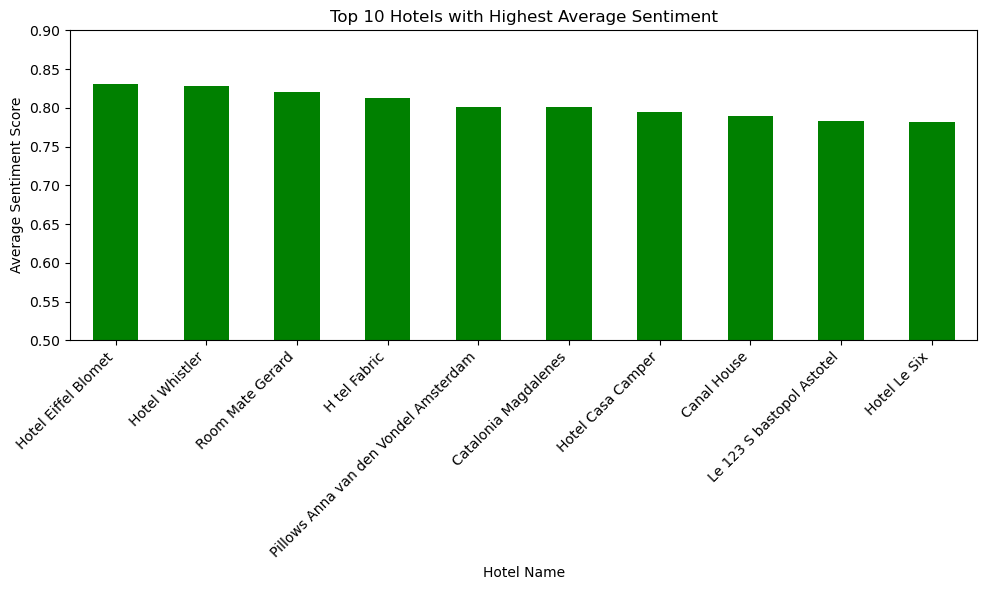

In [110]:
# Plot our results
plt.figure(figsize=(10, 6))
ax = top_10_hotels.plot(kind='bar', color='green')
plt.title('Top 10 Hotels with Highest Average Sentiment')
plt.xlabel('Hotel Name')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
ax.set_ylim(0.5, 0.9)
plt.tight_layout()
plt.show()

In [117]:
# Identify the top 10 hotels in terms of negative reviews
neg_average_sentiment_per_hotel = df.groupby('Hotel_Name')['Negative_Sentiment'].mean()
neg_sorted_hotels = neg_average_sentiment_per_hotel.sort_values(ascending=True)
neg_top_10_hotels = neg_sorted_hotels.head(10)

print(neg_top_10_hotels)

Hotel_Name
Kube Hotel Ice Bar        -0.262811
Hotel Liberty             -0.197155
Room Mate Gerard          -0.170343
Villa Lut ce Port Royal   -0.153700
Hotel G tico              -0.146708
Boundary Rooms Suites     -0.126133
Eurohotel Diagonal Port   -0.120069
Hotel Seven One Seven     -0.118741
Sansi Pedralbes           -0.117707
Hotel Wagner              -0.115890
Name: Negative_Sentiment, dtype: float64


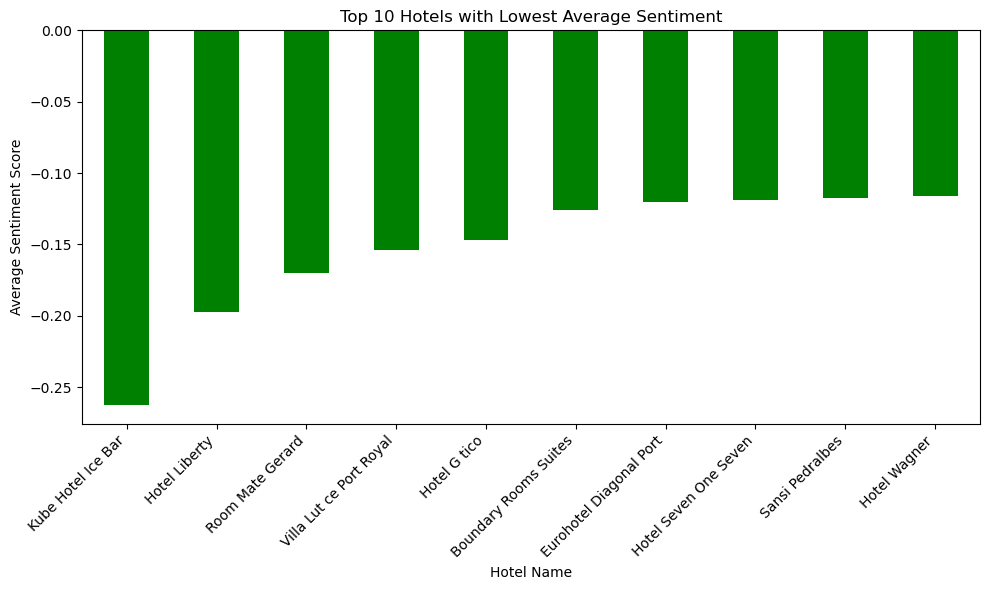

In [118]:
# Plot our results
plt.figure(figsize=(10, 6))
ax = neg_top_10_hotels.plot(kind='bar', color='green')
plt.title('Top 10 Hotels with Lowest Average Sentiment')
plt.xlabel('Hotel Name')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [122]:
# Find the average sentiment per country
country_df = df.groupby('Hotel_Address')['Positive_Sentiment'].mean()
sorted_hotels_by_country = country_df.sort_values(ascending=False)
display(sorted_hotels_by_country)

Hotel_Address
Barcelona, Spain          0.602541
Amsterdam, Netherlands    0.593454
Vienna, Austria           0.589908
Paris, France             0.579600
Milan, Italy              0.561473
London, United Kingdom    0.555720
Name: Positive_Sentiment, dtype: float64

In [123]:
# Find the average sentiment per country
country_df = df.groupby('Hotel_Address')['Negative_Sentiment'].mean()
sorted_hotels_by_country = country_df.sort_values(ascending=True)
display(sorted_hotels_by_country)

Hotel_Address
London, United Kingdom    0.007253
Milan, Italy              0.018569
Paris, France             0.018810
Barcelona, Spain          0.027399
Vienna, Austria           0.027833
Amsterdam, Netherlands    0.028539
Name: Negative_Sentiment, dtype: float64

Looking at positive sentiment, we can see that Spain has hotels with more positive reviews than the other countries and that the UK has the least positive reviews for their hotels. Although, a score of 0.55 still means that the average guest in a UK hotel had a fairly positive experience. Looking at the negative sentiment, once again we see the UK with the worst score. This would imply that on average hotels in the UK are worse than the rest. Furthermore, the Netherlands seems to have the least amount bad reviews. This along with the fact that the Netherlands has the second most positive reviews, implies that hotels in the Netherlands, on average, provide a better experience for their guests.